# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

---

The select from following methods by specifying `how` in [HindcastEnsemble.remove_bias](api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias):

- ``how="additive_mean"``: correcting the mean forecast additively (already implemented)
- ``how="multiplicative_mean"``: correcting the mean forecast multiplicatively
- ``how="multiplicative_std"``: correcting the standard deviation multiplicatively

Wrapped from the github package [bias_correction](https://github.com/pankajkarman/bias_correction/blob/master/bias_correction.py):

- ``how="modified_quantile"``: [Reference](https://www.sciencedirect.com/science/article/abs/pii/S0034425716302000?via%3Dihub)
- ``how="basic_quantile"``: [Reference](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.2168)
- ``how="gamma_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)
- ``how="normal_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

<IPython.core.display.Javascript object>

In [3]:
hind = climpred.tutorial.load_dataset(
    "CESM-DP-SST"
)  # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset("ERSST")  # observations
hind["lead"].attrs["units"] = "years"

<IPython.core.display.Javascript object>

We begin by removing a mean climatology for the observations, since `CESM-DPLE` generates its anomalies over this same time period.

In [4]:
obs = obs - obs.sel(time=slice("1964", "2014")).mean("time")

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='SST'>

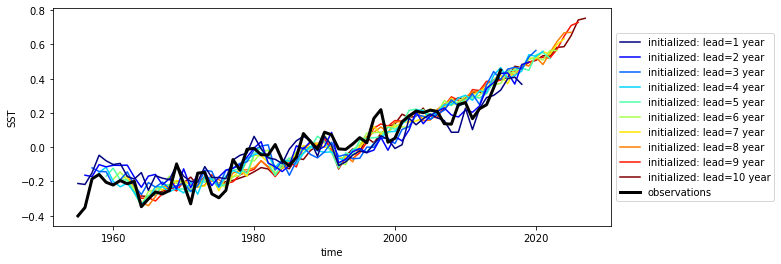

<IPython.core.display.Javascript object>

In [5]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs)
hindcast.plot()

The warming of the `observations` is similar to `initialized`.

## Additive mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on `lead`.

In [6]:
bias = hindcast.verify(metric="bias", comparison="e2o", dim=[], alignment="same_verifs")

<IPython.core.display.Javascript object>

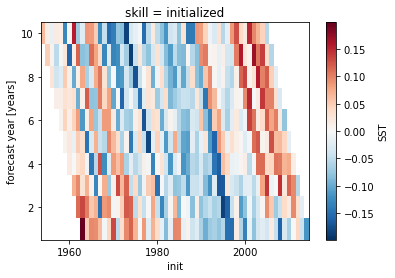

<IPython.core.display.Javascript object>

In [7]:
bias.SST.plot()

Against `observations`, there is small cold bias in 1980 and 1990 initialization years and warm bias before and after.

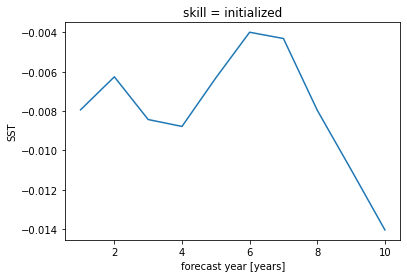

<IPython.core.display.Javascript object>

In [8]:
# lead-time dependant mean bias over all initializations is quite small but negative
mean_bias = bias.mean("init")
mean_bias.SST.plot()

### Cross Validatation
To remove the additive mean bias quickly, the mean bias over all initializations is subtracted. For formally correct bias removal with cross validation, the given initialization is [left out](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) when subtracting the mean bias.

`climpred` wraps these functions in `HindcastEnsemble.remove_bias(alignment, how=how, cross_validate={bool})`.

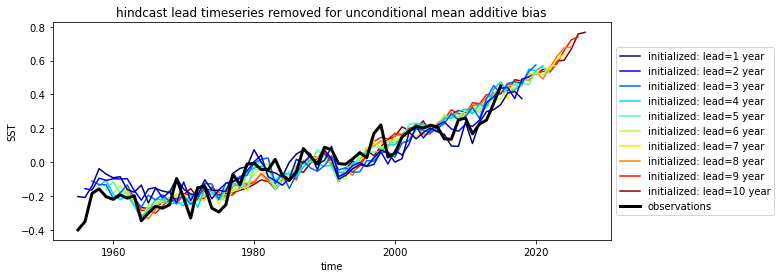

<IPython.core.display.Javascript object>

In [9]:
hindcast.remove_bias(
    how="additive_mean", cross_validate=True, alignment="same_verifs"
).plot()
plt.title("hindcast lead timeseries removed for unconditional mean additive bias")
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias removal. Correlations like (`pearson_r`, `spearman_r`) are insensitive to mean bias correction.

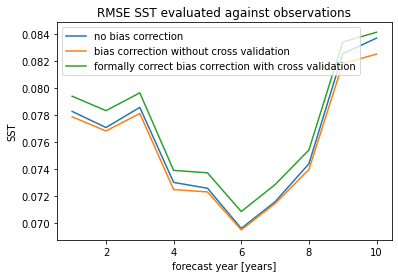

<IPython.core.display.Javascript object>

In [10]:
metric = "rmse"
hindcast.verify(metric=metric, comparison="e2o", dim="init", alignment="same_verifs")[
    "SST"
].plot(label="no bias correction")
hindcast.remove_bias(
    how="additive_mean", cross_validate=False, alignment="same_verifs"
).verify(metric=metric, comparison="e2o", dim="init", alignment="same_verifs").SST.plot(
    label="bias correction without cross validation"
)
hindcast.remove_bias(
    how="additive_mean", cross_validate=True, alignment="same_verifs"
).verify(metric=metric, comparison="e2o", dim="init", alignment="same_verifs").SST.plot(
    label="formally correct bias correction with cross validation"
)
plt.legend()
plt.title(f"{metric.upper()} SST evaluated against observations")
plt.show()